## Sentiment Analysis of the Safaricom Android Appication Reviews

Traditionally to know how you google play store app is doing, you would have to rely only on the reviews and store admin reports.In this exercise we are going to use sentiment analysis to augment the other data you get from the playstore and platforms like firebase to give additional context.

### Executive Summary
There are more positive reviews than neutral or negative ones. Also, there a strong correlation between sentiments and reviews in the play store. The latest version **1.20.2.3** has an average review of **4.3/5** and an average sentiment score of **0.4/1**. The average app reviews (**4.48**) and sentiments (**0.42**) started on high note in **2023** and began to drop until the start of *Q4* when it started to pick up again.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

In [2]:


sns.set_style("whitegrid")
import json
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

In [3]:
df_busu = pd.read_csv('safaricom_app_reviews.csv')
df_busu['time'] = pd.to_datetime(df_busu['at'])
# df_busu = df_busu[df_busu['time'] >= '2022-01-01']
# df_busu = pd.DataFrame(np.array(us_reviews),columns=['review'])
# df_busu = df_busu.join(pd.DataFrame(df_busu.pop('review').tolist()))
df_busu.head()

,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,time
0,0,5deb3745-2dd0-4fb1-b3f7-639b0f0acd90,Antony Wambua,https://play-lh.googleusercontent.com/a-/ALV-U...,This app is not opening on my phone What is th...,5,0,1.20.2.3,2023-11-08 13:55:02,NaN,NaN,1.20.2.3,2023-11-08 13:55:02
1,1,63bee2ed-e9fd-477a-9083-b7126ef6f282,GODWIN MAGORO,https://play-lh.googleusercontent.com/a-/ALV-U...,very reliable,4,0,1.20.2.3,2023-11-08 12:46:53,NaN,NaN,1.20.2.3,2023-11-08 12:46:53
2,2,f226c6f3-1589-4748-8b57-cd40418794f7,Jeff Muya,https://play-lh.googleusercontent.com/a-/ALV-U...,loving it,4,0,1.20.2.3,2023-11-08 11:54:13,NaN,NaN,1.20.2.3,2023-11-08 11:54:13
3,3,f850634d-7b8a-45e2-a4bc-39cb96a68474,ANTONY MBATHA,https://play-lh.googleusercontent.com/a-/ALV-U...,nice app but need to be added description opti...,4,0,1.20.2.3,2023-11-08 11:41:37,NaN,NaN,1.20.2.3,2023-11-08 11:41:37
4,4,5dad3a1b-227c-412d-8334-37e6053f938a,Elizabeth Ngigi,https://play-lh.googleusercontent.com/a/ACg8oc...,Reliable and fast,5,0,1.20.2.3,2023-11-08 11:19:59,NaN,NaN,1.20.2.3,2023-11-08 11:19:59


In [4]:
df_busu.shape

(39717, 13)

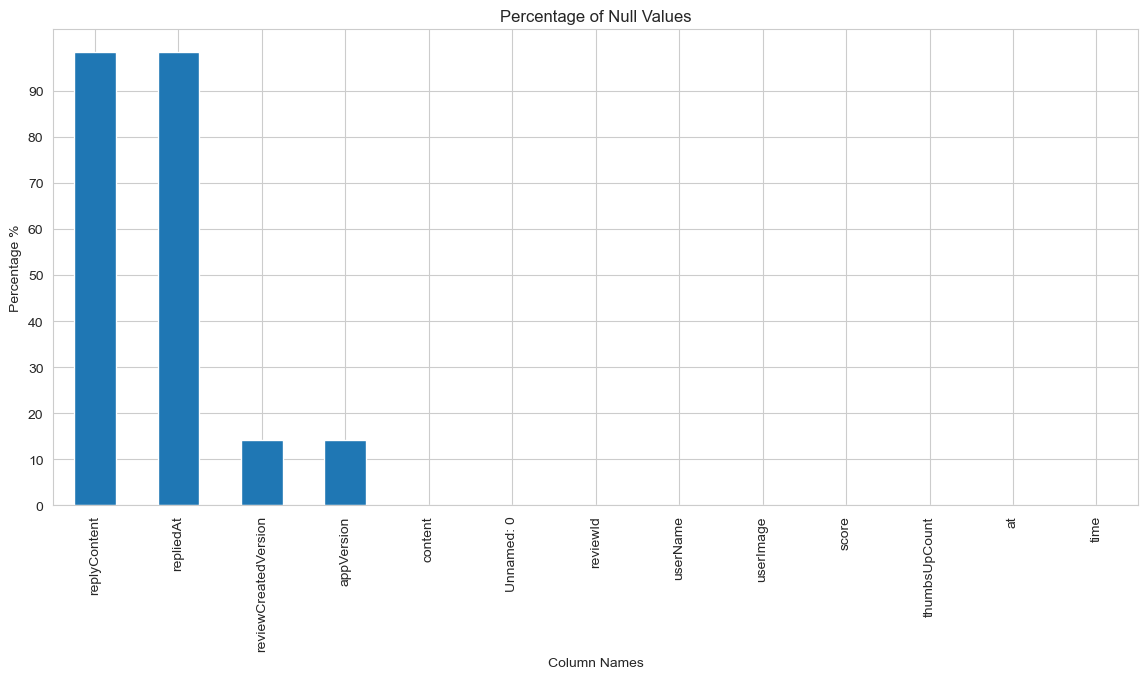

In [5]:
# Calculate the percentage of null values for each column
total_rows = len(df_busu)
null_counts = df_busu.isnull().sum()

# Sort the columns in descending order of null value counts
sorted_null_counts = null_counts.sort_values(ascending=False)

# Select top 20 columns
top_20_null_counts = sorted_null_counts.head(20)

# Calculate percentage for these top 20 columns
top_20_null_percentage = (top_20_null_counts / total_rows) * 100

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
top_20_null_percentage.plot(kind='bar')
ax.set_title('Percentage of Null Values')
ax.set_ylabel('Percentage %')
ax.set_xlabel('Column Names')
ax.set_yticks(np.arange(0, 100, 10))
# ax.axhline(y=threshold, color=shouting_clr_r, linestyle='--')  # Here 'r' specifies the color red and '--' specifies a dashed line.
#Add caption
fig.subplots_adjust(bottom=0.2)  # Adjust the bottom margin to make space for the caption
plt.show()

Not a lot of missing data, we are going to assume that the nulls in *replyContent* column were reviews without text. Some nulls exist *reviewCreatedVersion* and *appVersion* -- not sure why.

In [6]:
df_busu[df_busu['repliedAt'].isna()].shape

(39068, 13)

In [7]:
df_busu[df_busu['replyContent'].isna()].shape

(39068, 13)

In [8]:
df_busu[df_busu['reviewCreatedVersion'].isna()].shape

(5645, 13)

In [9]:
df_busu[df_busu['appVersion'].isna()].shape

(5645, 13)

In [10]:
content = df_busu['content'].shape

The image below shows there are more positive reviews than neutral and negative reviews -- which means majority of the customers like the app.

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/wamaebenson/nltk_data...


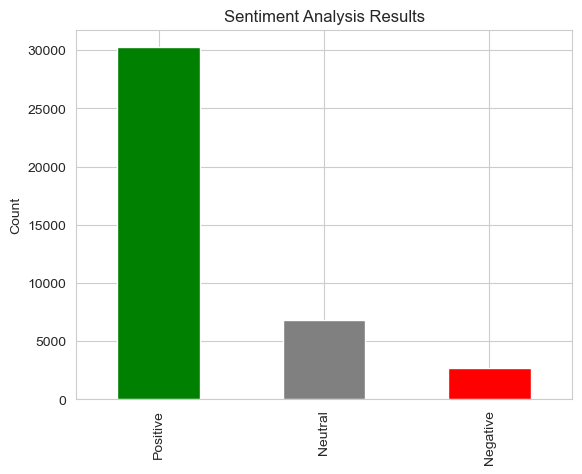

In [11]:
# Download VADER lexicon if you haven't already
nltk.download('vader_lexicon')

# Create a SentimentIntensityAnalyzer object
analyzer = SentimentIntensityAnalyzer()


def get_sentiment_score(text):
    sentiment_scores = analyzer.polarity_scores(str(text))
    return sentiment_scores['compound']

# Function to determine sentiment label
def get_sentiment(text):
    value = get_sentiment_score(text)

    if value >= 0.05:
        return "Positive"
    elif value <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment analysis to the 'TextData' column and create a new 'Sentiment' column
df_busu['sentiment'] = df_busu['content'].apply(get_sentiment)
df_busu['sentiment_val'] = df_busu['content'].apply(get_sentiment_score)

# Group the data by sentiment and count the occurrences
sentiment_counts = df_busu['sentiment'].value_counts()

# Create a bar graph to visualize sentiment distribution
sentiment_counts.plot(kind='bar', color=['green', 'grey', 'red'])
plt.ylabel('Count')
plt.title('Sentiment Analysis Results')
plt.show()

The image below shows some of the positive and negative words in the app. Some words might seem to be out of context e.g. "app" is not a negative word but if we pull some sample from the data frame we can see that it depends on the context -- the analysis is not perfect though; with a narrowed scope e.g. version, a more thorough analysis can be performed.

Positive words


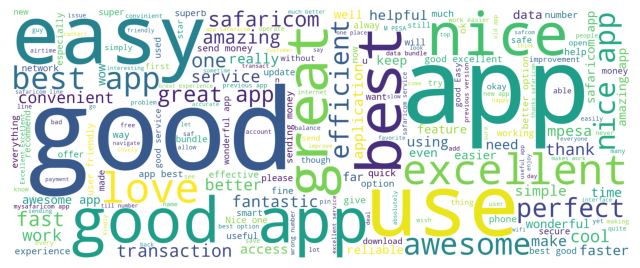

Negative words


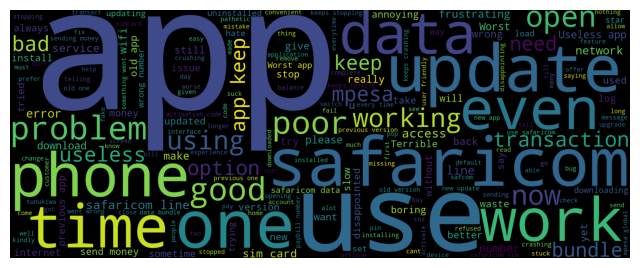

In [12]:
def wordcloud_draw(df2, color = 'black'):
    words = ' '.join(df2['content'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2000,
                      height=800
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(8, 40))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Positive words")
train_pos = df_busu[df_busu['sentiment'] == 'Positive']
train_neg = df_busu[df_busu['sentiment'] == 'Negative']
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

In [13]:
pd.set_option('display.max_colwidth', None)
df_neg_sentiment = df_busu[df_busu['sentiment'] == 'Negative']
df_neg_sentiment = df_neg_sentiment[df_neg_sentiment['content'].str.contains('app', case=False, na=False)]
df_neg_sentiment[['sentiment','sentiment_val','content']].head()

,sentiment,sentiment_val,content
9,Negative,-0.4118,Was a good app but now its nolonger working its waste of time and resources in downloading safaricom has to check on it
381,Negative,-0.2665,very good app no sending money to wrong number
404,Negative,-0.4215,Useless app its not working
421,Negative,-0.4767,Why does this app start behaving badly
460,Negative,-0.1280,Good app it has no adds and one can buy bundle I've had no airtme


In [14]:
# @title
# Convert the 'time' column to datetime
df_busu['time'] = pd.to_datetime(df_busu['at'])
# Filter the DataFrame for dates >= '2022-09'
# df_busu = df_busu[df_busu['time'] >= '2022-01-01']

In [15]:
df_busu['month'] = df_busu['time'].dt.strftime("%B")
df_busu['month_num'] = df_busu['time'].dt.month
df_busu['year'] = df_busu['time'].dt.strftime("%Y")
df_busu['month_year'] = df_busu['time'].dt.to_period("M")

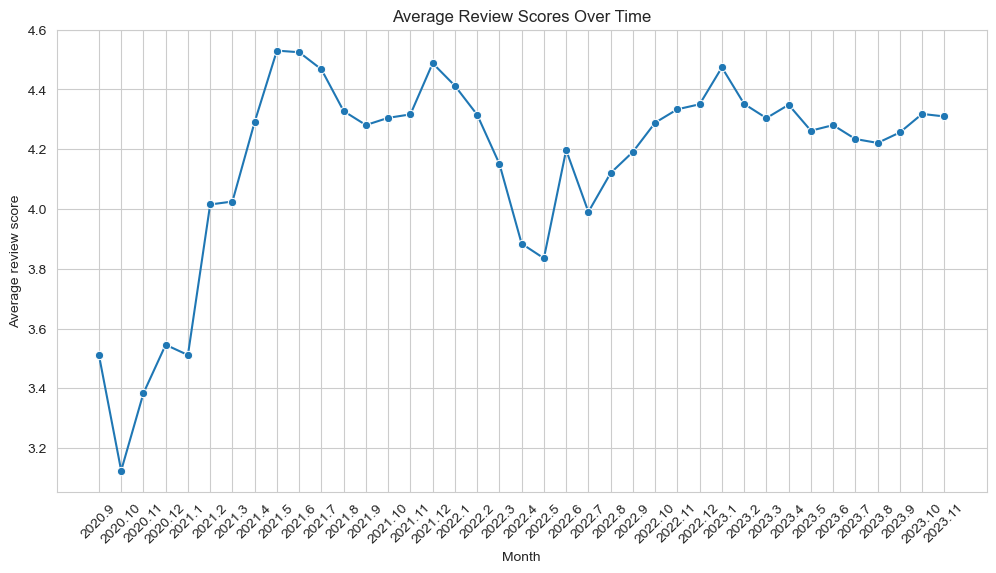

In [16]:
# Group by unique months in each year and calculate the mean score
grouped_df = df_busu.groupby([df_busu['year'], df_busu['month_num']])['score'].mean().reset_index()
grouped_df['year_month'] = grouped_df['year'].astype(str)+"."+grouped_df['month_num'].astype(str)
# Plotting using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='year_month', y='score', data=grouped_df, marker='o')

plt.xlabel('Month')
plt.ylabel('Average review score')
plt.title('Average Review Scores Over Time')
plt.xticks(rotation=45)

plt.show()

Interestingly the mean sentiment score seems to have some kind of correlation with the reviews on the Google Play Store.

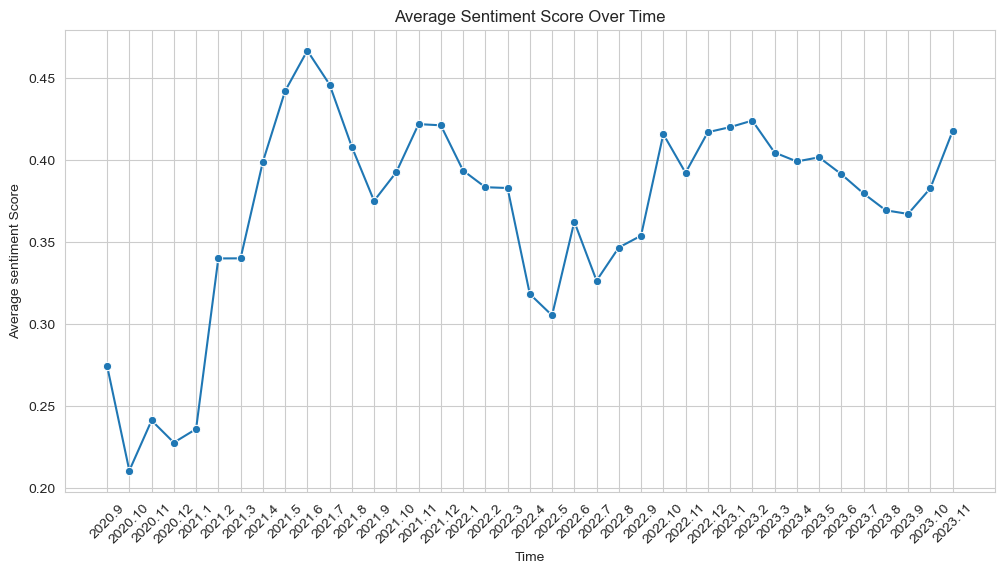

In [17]:
# Group by unique months in each year and calculate the mean score
grouped_df = df_busu.groupby([df_busu['year'], df_busu['month_num']])['sentiment_val'].mean().reset_index()
grouped_df['year_month'] = grouped_df['year'].astype(str)+"."+grouped_df['month_num'].astype(str)
# Plotting using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='year_month', y='sentiment_val', data=grouped_df, marker='o')

plt.xlabel('Time')
plt.ylabel('Average sentiment Score')
plt.title(f"Average Sentiment Score Over Time")
plt.xticks(rotation=45)
plt.show()

In [18]:
df_busu['reviewCreatedVersion'].unique()

array(['1.20.2.3', '1.20.1.10', '1.9.0', nan, '1.19.0.8', '1.17.1.15',
       '1.15.0.12', '1.6.1', '1.1.1', '1.13.1.1', '1.10.0', '1.18.0.11',
       '1.12.0.7', '1.16.1.1', '1.11.0.12', '1.4.0', '1.14.0.17',
       '1.16.0.5', '1.0.0', '1.2.0', '1.8.0', '1.3.0', '1.1.0', '1.7.1',
       '1.6.0', '1.0.0-beta13', '1.0.0-beta15'], dtype=object)

In [19]:
# TODO: This is temporary - Remove beta from version name
df_busu['reviewCreatedVersion'] = df_busu['reviewCreatedVersion'].str.replace('-beta', '')

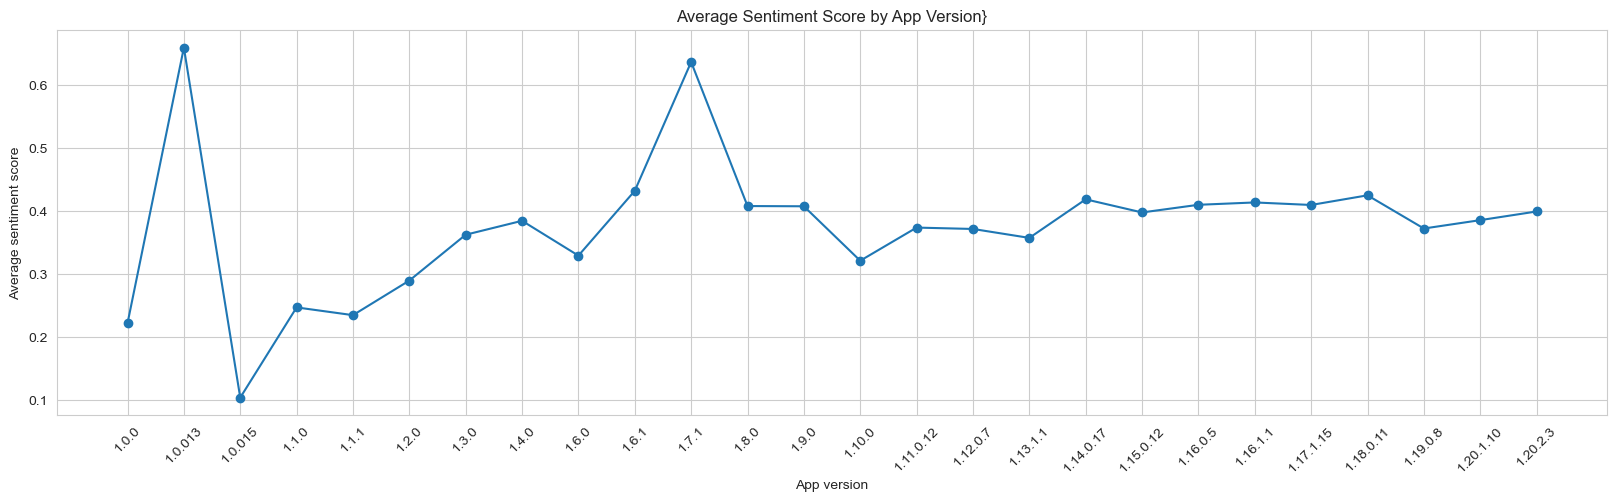

In [20]:
def version_to_int(version):
    major, minor, tiny, *build = map(int, version.split("."))
    build_value = build[0] if build else 0
    
    major = (major << 24) & 0xFF000000
    minor = (minor << 16) & 0x00FF0000
    tiny = (tiny << 12) & 0x0000F000
    build = build_value & 0x00000FFF if build else 0
    return int(major | minor | tiny | build)

df2 = pd.DataFrame(df_busu.groupby(['reviewCreatedVersion'])['sentiment_val'].mean()).reset_index()

df2['version_ordered'] = df2.reviewCreatedVersion.apply(version_to_int)

df2 = df2.sort_values(by='version_ordered', ascending=True)

plt.figure(figsize=(20, 5))
plt.plot(df2['reviewCreatedVersion'], df2['sentiment_val'], marker='o')
plt.xlabel('App version')
plt.ylabel('Average sentiment score')
plt.title('Average Sentiment Score by App Version}')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [21]:
df_1_3_0 = df_busu[df_busu['reviewCreatedVersion'] == '1.3.0']
df_1_3_0.head()

,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,time,sentiment,sentiment_val,month,month_num,year,month_year
8135,8135,8a93cfb4-35df-4f03-9a29-b0522eb57b5a,Hassan Salim,https://play-lh.googleusercontent.com/a-/ALV-UjXKZvePSKuLYIdO0R2qEwUazyBf7PA48JnOV6iPJv1eNw,Excellent App,5,1,1.3.0,2022-11-23 22:28:36,NaN,NaN,1.3.0,2022-11-23 22:28:36,Positive,0.5719,November,11,2022,2022-11
9735,9735,c526bd8c-d2e2-421c-9b54-96a8a001efae,Aden Mukhtar sheikh abud,https://play-lh.googleusercontent.com/a-/ALV-UjUoa8YBcE3WeMllctOdGmJJa_Z-vL0ONa5xivJipPQ7yA,M.a,5,0,1.3.0,2022-09-19 08:19:01,NaN,NaN,1.3.0,2022-09-19 08:19:01,Neutral,0.0000,September,9,2022,2022-09
10788,10788,cae01a91-1afb-4ca6-b120-64f192fd96bf,Jane Kitonyi Kahia,https://play-lh.googleusercontent.com/a/ACg8ocKqG959RRgEq_YZGZDCzINddwqiQ-X9ceunAROjQB6B=mo,Not bad use it,5,0,1.3.0,2022-08-08 22:51:09,NaN,NaN,1.3.0,2022-08-08 22:51:09,Positive,0.4310,August,8,2022,2022-08
11473,11473,ae80034d-6e79-47dd-9ba3-8c9aa99d135d,kennedy rateng,https://play-lh.googleusercontent.com/a-/ALV-UjWLW3qrH-x4wWN_GLxKDzhmkns_hymG7UYe4OXOd3oGgaQ,Horrible and disgusting. The app have got bugs,1,0,1.3.0,2022-07-15 20:24:11,NaN,NaN,1.3.0,2022-07-15 20:24:11,Negative,-0.7845,July,7,2022,2022-07
12462,12462,0569a31e-bfd8-417c-9306-70dbc069ca34,talib mutongi,https://play-lh.googleusercontent.com/a-/ALV-UjU8s1zV4ewmQK9xeeqEYP4aing9PztFLrnoPdOu-A1Xtnyh,The app now keeps stopping! Cant use it.,4,0,1.3.0,2022-06-14 19:40:25,NaN,NaN,1.3.0,2022-06-14 19:40:25,Negative,-0.2244,June,6,2022,2022-06


Version 1.3.0 had the lowest sentiment and review score. The images below shows an excerpt of some interesting words in the reviews. Additionally, we have included some sample reviews for the version.

Positive words


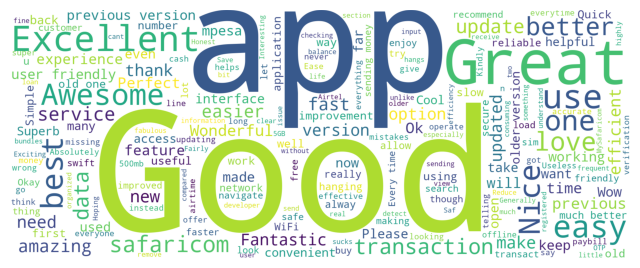

Negative words


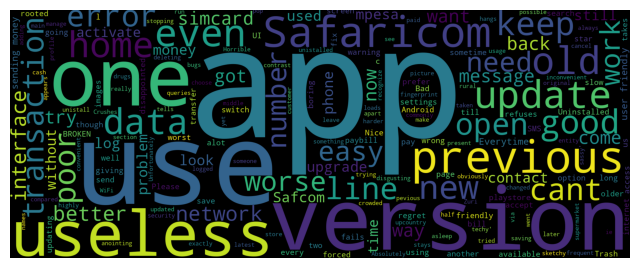

In [22]:
print("Positive words")
train_pos = df_1_3_0[df_1_3_0['sentiment'] == 'Positive']
train_neg = df_1_3_0[df_1_3_0['sentiment'] == 'Negative']
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

In [23]:
train_neg[['sentiment','sentiment_val','content']].head()

,sentiment,sentiment_val,content
11473,Negative,-0.7845,Horrible and disgusting. The app have got bugs
12462,Negative,-0.2244,The app now keeps stopping! Cant use it.
13556,Negative,-0.4754,What is really wrong with this app so anointing 😡😡😡😠 which safaricom simcard do you want us to present 😏😏
30434,Negative,-0.4215,It fails some times. Otherwise convenient
31502,Negative,-0.6449,WE NEED THE PREVIOUS APP!!!!!.... don't you use your own app and see its worse than the previous?


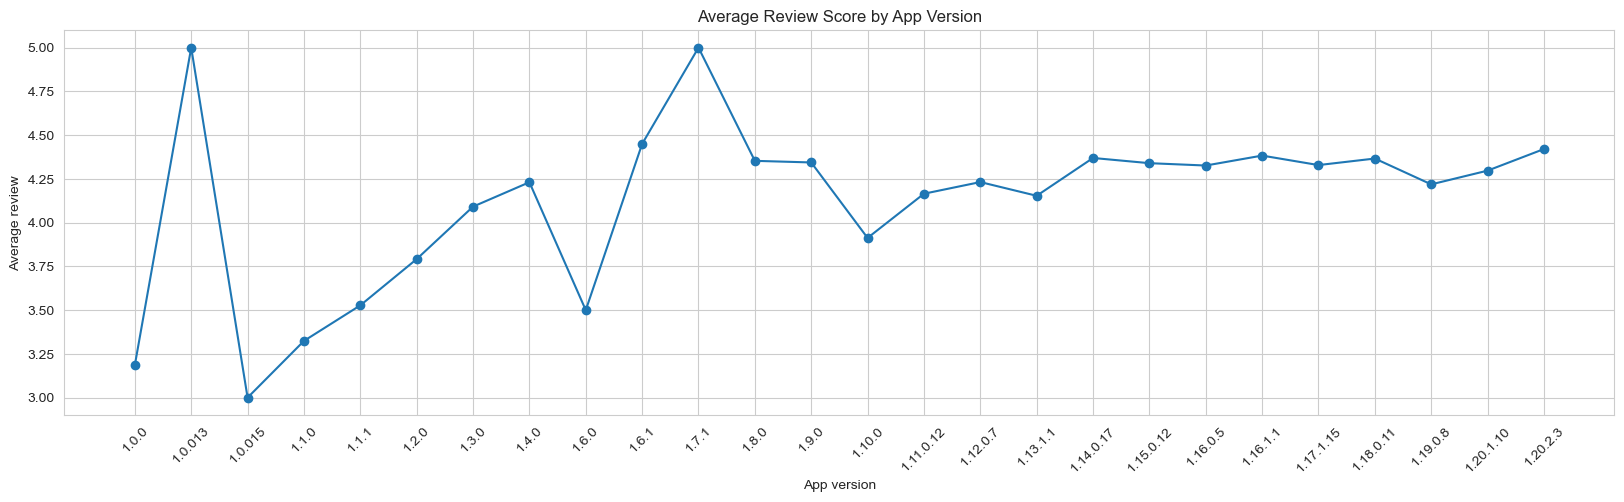

In [24]:
df3 = pd.DataFrame(df_busu.groupby('reviewCreatedVersion')['score'].mean()).reset_index()

df3['version_ordered'] = df3.reviewCreatedVersion.apply(version_to_int)

df3 = df3.sort_values(by='version_ordered', ascending=True)

plt.figure(figsize=(20, 5))
plt.plot(df3['reviewCreatedVersion'], df3['score'], marker='o')
plt.xlabel('App version')
plt.ylabel('Average review')
plt.title('Average Review Score by App Version')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

**References:**

https://www.kaggle.com/code/ngyptr/python-nltk-sentiment-analysis
